Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [99]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_forward_min_pot_min_prime"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80
MINDEST_POTENTIAL = 80
CENTRAL = 1
OFFENSE = 1

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']

PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','Composure','Interceptions','Age',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'BallControl',  'SprintSpeed', 'Agility'
       'Reactions',  'ShotPower', 'Jumping',  'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  'HeadingAccuracy','prime_age']

PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','Composure','Interceptions','Age','Reactions',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'BallControl',  'SprintSpeed', 'Agility','Acceleration',
       'Reactions',  'ShotPower', 'Jumping',  'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  'HeadingAccuracy']

PLAYER_ATTRIBUTES = ['Finishing','HeadingAccuracy','ShortPassing',  'Dribbling', 'BallControl',  'Agility', 
                     'Reactions', 'Strength', 'LongShots', 'Aggression',  'Positioning', 'Vision','SprintSpeed',
                     'Volleys','Penalties'
                     ]


In [100]:
%load_ext autoreload
%autoreload 2

import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")

find_and_append_module_path()

import os
import warnings
from datetime import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

from prediction_prime_overall.src.prepare import (
    add_features_raw,
    select_features
)
from prediction_prime_overall.src.eval import (
    plot_feature_importance,
    plot_shap_summary,
    plot_auc_curves,
    log_metrics_in_mlflow_regression,
    log_metrics_in_mlflow,
    log_feature_list_as_artifact
)
import prediction_prime_overall.config as CONFIG
from prediction_prime_overall.src.utils import *


mlflow.set_tracking_uri("file:///"+CONFIG.MLFLOW)
mlflow.set_experiment(EXPERIEMENT_NAME)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
New current directory: c:\Users\Robert\Documents\Projekte\statsfaction


<Experiment: artifact_location='file:///c:\\Users\\Robert\\Documents\\Projekte\\statsfaction\\prediction_prime_overall\\data\\mlflow/319009839572348588', creation_time=1704286246816, experiment_id='319009839572348588', last_update_time=1704286246816, lifecycle_stage='active', name='offense_potential_forward_min_pot_min_prime', tags={}>

### Get Data


In [101]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(
  SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  

(SELECT *,Potential as max_potential FROM fifa WHERE Potential>={MINDEST_POTENTIAL})
GROUP BY ID
order by potential DESC;
"""



In [102]:


# Step 1: Establish a database connection
conn = sqlite3.connect(CONFIG.DATABASE)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,league,club_prestige,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,None,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,None,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,None,NaN,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,None,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,None,NaN,90.0,21.0,81.0,RW,0,1,1.0,25.0


# 

In [103]:
df_raw[df_raw.index.get_level_values('ID')==239085].prime_age

ID      Name       FIFA
239085  E. Håland  2020    22.0
Name: prime_age, dtype: float64

In [104]:
# df_raw["Potential"] = df_raw.Potential.astype('float')
# df_raw["max_potential"] = df_raw.max_potential.astype('float')

In [105]:
df = df_raw.copy()

year_to_category = {2011: 'train', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'test', 2019: 'test', 2020: 'test', 2021: 'valid', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [106]:
df[df.prime_age>df.potential_age]

,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,club_prestige,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense,set
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0,train
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0,train
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0,train
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,NaN,90.0,21.0,81.0,RW,0,1,1.0,25.0,valid
255475,Antony,2021,20.0,20.0,https://cdn.sofifa.net/players/255/475/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,78.0,88.0,Ajax,https://cdn.sofifa.net/meta/team/629/30.png,€31M,...,NaN,88.0,22.0,82.0,RW,0,1,1.0,36.0,valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183916,J. Pied,2011,21.0,21.0,https://cdn.sofifa.net/players/183/916/11_60.png,France,https://cdn.sofifa.net/flags/fr.png,67.0,82.0,Olympique Lyonnais,https://cdn.sofifa.net/meta/team/79/30.png,€0,...,NaN,82.0,27.0,75.0,RF,0,1,1.0,11.0,train
164467,J. Ward,2011,24.0,24.0,https://cdn.sofifa.net/players/164/467/11_60.png,Northern Ireland,https://cdn.sofifa.net/flags/gb-nir.png,71.0,82.0,Sheffield United,https://cdn.sofifa.net/meta/team/21/30.png,€0,...,NaN,82.0,25.0,72.0,RF,0,1,1.0,16.0,train
193268,A. Gerbo,2011,20.0,20.0,https://cdn.sofifa.net/players/193/268/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,60.0,80.0,Triestina,https://cdn.sofifa.net/meta/team/3890/30.png,€0,...,NaN,80.0,29.0,65.0,RF,0,1,1.0,22.0,train


In [107]:
df = df[(df.central == CENTRAL)&(df.offense ==OFFENSE)]

# Training nur auf High Potentials
df = df[df.max_potential>MINDEST_POTENTIAL]

# nur Entwicklugnsfähige Spieler
BOOL_DEVELOPMENT_TIME = (df.prime_age-df.potential_age)>0

df = df[BOOL_DEVELOPMENT_TIME]
# df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
78.0    35
73.0    26
75.0    26
77.0    25
74.0    23
76.0    23
70.0    18
72.0    16
79.0    15
81.0    14
69.0    14
80.0    13
84.0    12
68.0    11
82.0    10
71.0    10
64.0     9
67.0     8
83.0     8
66.0     5
65.0     3
87.0     3
89.0     3
92.0     2
86.0     2
63.0     2
88.0     2
85.0     1
91.0     1
90.0     1
59.0     1
62.0     1
57.0     1
Name: count, dtype: int64


In [108]:
df_overview = df[df.prime_age>df.potential_age][["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]]
df_overview.head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
186405,F. di Santo,2011,21.0,21.0,27.0,90.0,90.0,74.0,77.0,77.0,train,ST
199266,Ji Dong Won,2011,19.0,19.0,22.0,89.0,89.0,66.0,71.0,71.0,train,ST
253002,G. Raspadori,2022,21.0,21.0,22.0,88.0,88.0,74.0,79.0,79.0,valid,ST
240833,Y. Moukoko,2023,17.0,17.0,18.0,88.0,88.0,69.0,77.0,77.0,valid,ST
231677,M. Rashford,2017,18.0,18.0,25.0,88.0,88.0,76.0,84.0,84.0,train,ST


In [ ]:
df_overview.set.value_counts()/len(df_overview)

<Axes: >

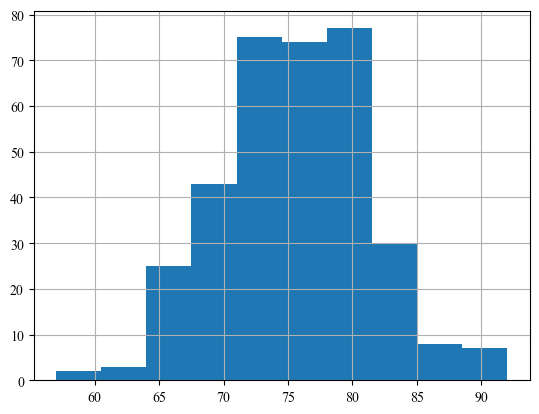

In [109]:
df_overview.target.hist()

In [110]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [111]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Att. Position', 'Composure', 'Defensive awareness', 'Preferred foot',
       'Skill moves', 'Weak foot', 'International reputation', 'Work rate',
       'Body type', 'Real face', 'birthDate', 'league', 'club_prestige'],
      dtype='object')

#### Transform Value

In [112]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

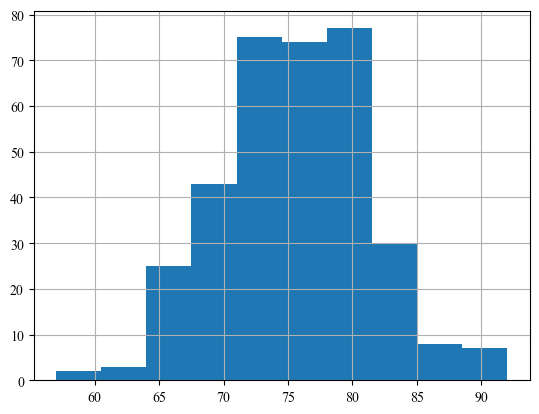

In [113]:
df['target'].hist()

In [114]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [115]:
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [116]:


# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')


# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [117]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [118]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [119]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


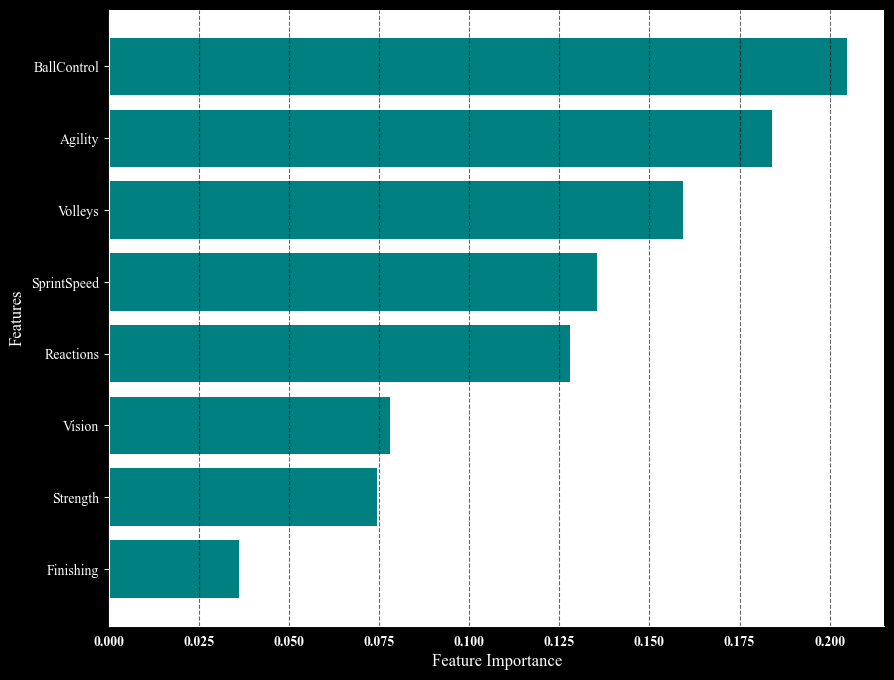

100%|██████████| 30/30 [00:03<00:00,  7.93it/s]


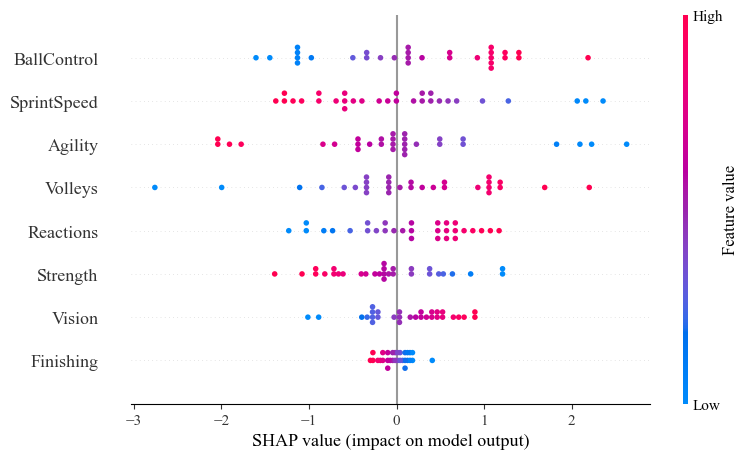

              precision    recall  f1-score   support

       False       0.89      0.97      0.93        74
        True       0.00      0.00      0.00         9

    accuracy                           0.87        83
   macro avg       0.44      0.49      0.46        83
weighted avg       0.79      0.87      0.83        83

Huber Regression training----->


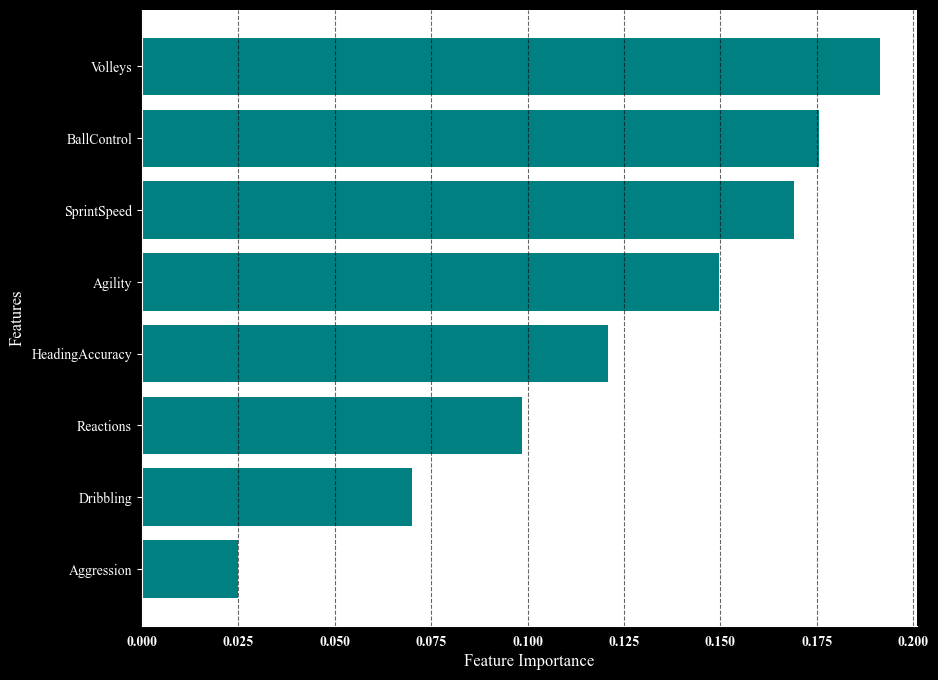

100%|██████████| 30/30 [00:03<00:00,  8.56it/s]


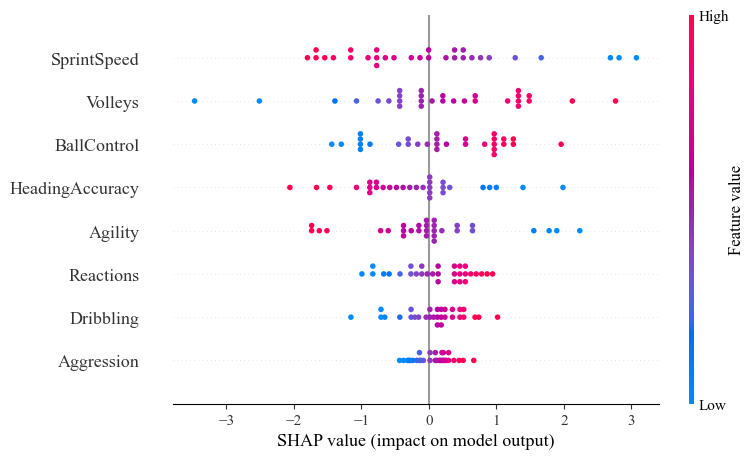

              precision    recall  f1-score   support

       False       0.89      0.99      0.94        74
        True       0.00      0.00      0.00         9

    accuracy                           0.88        83
   macro avg       0.45      0.49      0.47        83
weighted avg       0.79      0.88      0.83        83

Linear Regression training----->


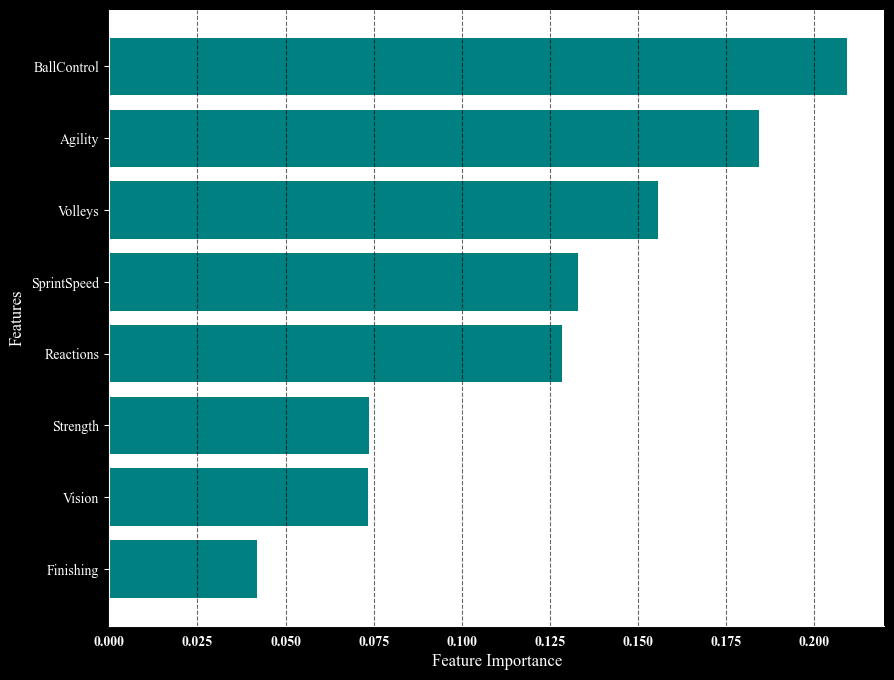

100%|██████████| 30/30 [00:03<00:00,  8.59it/s]


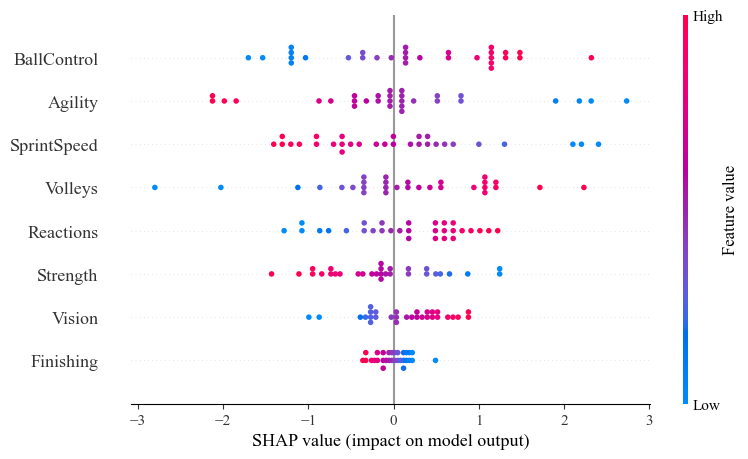

              precision    recall  f1-score   support

       False       0.89      0.97      0.93        74
        True       0.00      0.00      0.00         9

    accuracy                           0.87        83
   macro avg       0.44      0.49      0.46        83
weighted avg       0.79      0.87      0.83        83

Model: Ridge Regression
Mean Squared Error: 24.41
Mean Absolute Error: 3.91
R2 Score: 0.09

Model: Huber Regression
Mean Squared Error: 24.13
Mean Absolute Error: 3.97
R2 Score: 0.10

Model: Linear Regression
Mean Squared Error: 24.41
Mean Absolute Error: 3.91
R2 Score: 0.09



In [120]:



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    #  'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    #  'XGBoost Regressor': XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}

# Set the experiment name

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        

        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [121]:

if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [122]:
X_train.describe()

,Finishing,HeadingAccuracy,ShortPassing,Dribbling,BallControl,Agility,Reactions,Strength,LongShots,Aggression,Positioning,Vision,SprintSpeed,Volleys,Penalties
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,68.118227,60.551724,59.699507,67.216749,67.492611,69.753695,64.679803,62.748768,60.709360,48.147783,46.783251,57.137931,73.699507,60.876847,61.374384
std,16.734260,16.749790,16.136894,17.207307,16.975046,18.045828,16.728494,18.706724,15.957222,17.417922,33.240234,16.555059,18.036908,16.387921,16.558858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.000000,57.000000,57.000000,64.000000,66.000000,68.000000,62.000000,57.000000,58.000000,38.000000,0.000000,52.500000,73.000000,56.000000,58.000000
50%,71.000000,64.000000,63.000000,71.000000,71.000000,73.000000,69.000000,67.000000,64.000000,50.000000,65.000000,61.000000,77.000000,64.000000,66.000000
75%,76.000000,71.000000,68.500000,76.000000,75.000000,78.000000,73.500000,74.000000,70.000000,60.000000,73.000000,66.500000,82.000000,69.500000,70.000000
max,92.000000,83.000000,82.000000,92.000000,91.000000,95.000000,87.000000,93.000000,83.000000,79.000000,89.000000,83.000000,92.000000,87.000000,84.000000


In [123]:
y_test.describe()

count    83.000000
mean     74.325301
std       5.219823
min      65.000000
25%      70.500000
50%      74.000000
75%      77.000000
max      91.000000
Name: target, dtype: float64

In [124]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [125]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

83

<Axes: >

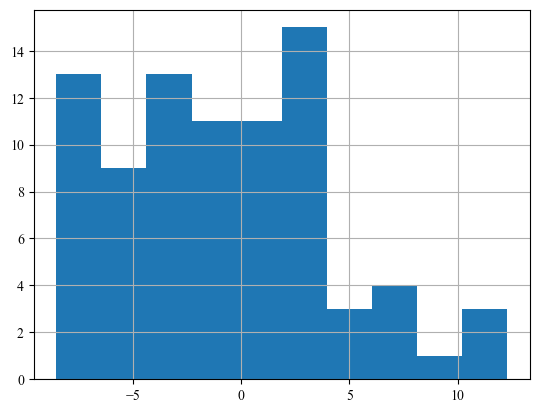

In [126]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

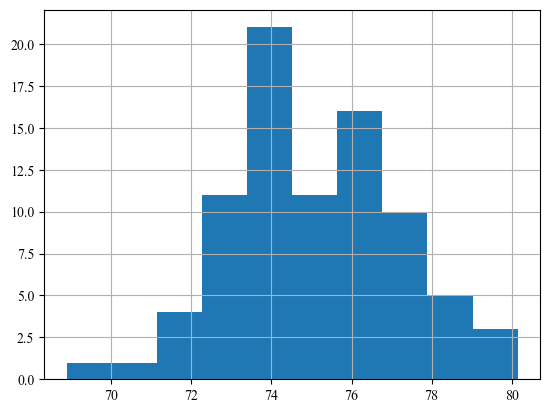

In [127]:
result_df.sort_values(ascending=False).hist()

In [128]:
(y_test-result_df).describe()

count    83.000000
mean     -0.746304
std       4.884495
min      -8.535230
25%      -4.590808
50%      -0.360991
75%       2.350426
max      12.288916
dtype: float64

# outlier detection

In [129]:
outlier = (y_test-result_df)>10
X_test[outlier]


,,,Finishing,HeadingAccuracy,ShortPassing,Dribbling,BallControl,Agility,Reactions,Strength,LongShots,Aggression,Positioning,Vision,SprintSpeed,Volleys,Penalties
ID,Name,FIFA,,,,,,,,,,,,,,,
231478,L. Martínez,2018,72.0,70.0,58.0,69.0,71.0,73.0,64.0,85.0,64.0,56.0,71.0,54.0,79.0,64.0,59.0
239085,E. Håland,2020,72.0,62.0,67.0,72.0,74.0,66.0,72.0,84.0,62.0,81.0,73.0,57.0,83.0,70.0,72.0
232293,V. Osimhen,2019,68.0,66.0,57.0,63.0,66.0,68.0,62.0,66.0,56.0,48.0,68.0,51.0,77.0,65.0,65.0


In [130]:
y_test[outlier]

ID      Name         FIFA
231478  L. Martínez  2018    87.0
239085  E. Håland    2020    91.0
232293  V. Osimhen   2019    88.0
Name: target, dtype: float64

In [131]:
result_df[outlier]

ID      Name         FIFA
231478  L. Martínez  2018    75.693080
239085  E. Håland    2020    79.450862
232293  V. Osimhen   2019    75.711084
dtype: float64

In [132]:
(y_test/result_df).describe()

count    83.000000
mean      0.990166
std       0.064728
min       0.889090
25%       0.940443
50%       0.995210
75%       1.031617
max       1.162313
dtype: float64

In [133]:
(y_test/result_df).describe()

count    83.000000
mean      0.990166
std       0.064728
min       0.889090
25%       0.940443
50%       0.995210
75%       1.031617
max       1.162313
dtype: float64

In [134]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.35702382],
       [0.35702382, 1.        ]])

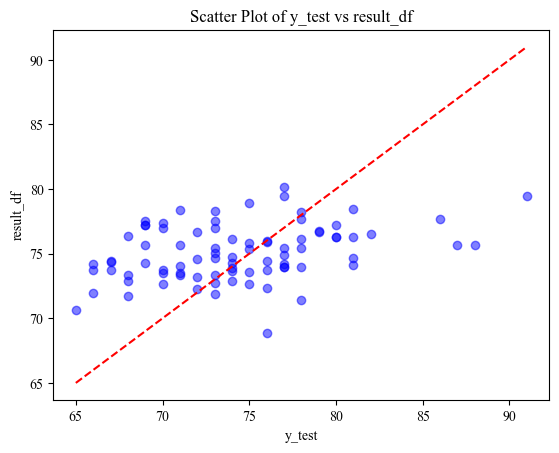

In [135]:

plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [136]:
result_df = result_df.sort_values(ascending=False)

In [137]:
sum(X_train_scaled_df.index.get_level_values('ID')==239085)

0

In [138]:
df_raw

,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,league,club_prestige,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,None,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,None,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,None,NaN,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,None,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,None,NaN,90.0,21.0,81.0,RW,0,1,1.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20486,Carlinhos Bala,2011,30.0,30.0,https://cdn.sofifa.net/players/020/486/11_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,69.0,81.0,Atlético GO,https://cdn.sofifa.net/meta/team/8331/30.png,€0,...,None,NaN,81.0,30.0,69.0,RF,0,1,1.0,44.0
193268,A. Gerbo,2011,20.0,20.0,https://cdn.sofifa.net/players/193/268/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,60.0,80.0,Triestina,https://cdn.sofifa.net/meta/team/3890/30.png,€0,...,None,NaN,80.0,29.0,65.0,RF,0,1,1.0,22.0
189437,C. Pasquato,2011,20.0,20.0,https://cdn.sofifa.net/players/189/437/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,67.0,80.0,Modena,https://cdn.sofifa.net/meta/team/1000/30.png,€0,...,None,NaN,80.0,21.0,73.0,RF,0,1,1.0,22.0


In [139]:
result_df.head(50)

ID      Name                FIFA
215689  A. Petagna          2018    80.148368
222041  L. Boyé             2018    79.460808
239085  E. Håland           2020    79.450862
248805  Sergio Camello      2020    78.887764
236786  M. Terrier          2019    78.427983
251105  D. Joveljić         2020    78.374599
252037  Fábio Silva         2020    78.265924
252324  Riquelme            2020    78.212932
241721  Rafael Leão         2020    77.708845
226766  Daniel Podence      2018    77.698218
248385  R. Piccoli          2020    77.535230
227732  A. Donis            2018    77.525081
246044  Andrés Martín       2020    77.382096
243652  Borja Garcés        2020    77.242267
231447  D. Malen            2020    77.219256
242965  F. Hornby           2020    77.202964
245437  A. Gaich            2020    77.006852
239953  Léo Jabá            2018    76.971943
236610  M. Kean             2018    76.743347
234333  M. Maolida          2018    76.656535
240753  A. Gouiri           2018    76.642784
2

In [140]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

0


Series([], dtype: float64)

In [141]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

12


ID      Name              FIFA
239085  E. Håland         2020    79.450862
236786  M. Terrier        2019    78.427983
241721  Rafael Leão       2020    77.708845
231447  D. Malen          2020    77.219256
233731  A. Isak           2018    76.518694
221479  D. Calvert-Lewin  2020    76.301681
246191  J. Álvarez        2020    76.290023
243630  J. David          2020    76.262821
232293  V. Osimhen        2019    75.711084
231478  L. Martínez       2018    75.693080
240690  N. González       2019    74.638849
240243  Matheus Cunha     2019    74.107326
dtype: float64

In [142]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

1


ID      Name        FIFA
215689  A. Petagna  2018    80.148368
dtype: float64

In [143]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

70


ID      Name            FIFA
239250  Abel Ruiz       2019    75.975655
244622  Puado           2020    76.100507
237539  L. Singh        2019    76.161233
237708  M. Sylla        2018    76.359448
240753  A. Gouiri       2018    76.642784
234333  M. Maolida      2018    76.656535
236610  M. Kean         2018    76.743347
239953  Léo Jabá        2018    76.971943
245437  A. Gaich        2020    77.006852
242965  F. Hornby       2020    77.202964
243652  Borja Garcés    2020    77.242267
246044  Andrés Martín   2020    77.382096
227732  A. Donis        2018    77.525081
248385  R. Piccoli      2020    77.535230
226766  Daniel Podence  2018    77.698218
252324  Riquelme        2020    78.212932
252037  Fábio Silva     2020    78.265924
251105  D. Joveljić     2020    78.374599
248805  Sergio Camello  2020    78.887764
222041  L. Boyé         2018    79.460808
dtype: float64

In [144]:

print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.60      0.52      0.56        50
        True       0.40      0.48      0.44        33

    accuracy                           0.51        83
   macro avg       0.50      0.50      0.50        83
weighted avg       0.52      0.51      0.51        83



In [145]:
X_train[X_train.index.get_level_values('ID')==239085]

,,,Finishing,HeadingAccuracy,ShortPassing,Dribbling,BallControl,Agility,Reactions,Strength,LongShots,Aggression,Positioning,Vision,SprintSpeed,Volleys,Penalties
ID,Name,FIFA,,,,,,,,,,,,,,,
